In [1]:
import argparse
import itertools
import os
import numpy as np
from numpy import save,load,savetxt,loadtxt,savez_compressed
from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize

import pandas as pd
import scipy.sparse as sp
import time
from tqdm import tqdm, tqdm_notebook,tnrange
tqdm.pandas(position=0, leave=True)
import math 
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl import edge_subgraph
import dgl.nn as dglnn
import dgl.function as fn

import functools
import seaborn as sns
import pickle
import random

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'
import warnings
warnings.filterwarnings('ignore')
import utils

print("torch version is {}".format(th.__version__))
print("DGL version is {}".format(dgl.__version__))

Using backend: pytorch


torch version is 1.6.0
DGL version is 0.8a210818


In [2]:
def seed_everything(seed):
    random.seed(seed)
    th.manual_seed(seed)
    th.cuda.manual_seed_all(seed)
    th.backends.cudnn.deterministic = True
    th.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(101)

#### load graph data

In [3]:
KG_dir="/workspace/cjiang/eagle_project/CAP_graph/BGNN/"

start=time.time()
with open(os.path.join(KG_dir,'CAP_Graph_v1'), 'rb') as f:
    hg,multi_label,binary_label,\
    train_mask_multi_label,  val_mask_multi_label,  test_mask_multi_label,\
    train_mask_binary_label, val_mask_binary_label, test_mask_binary_label= pickle.load(f)
end=time.time()
print("It took {:0.4f} seconds to load graph".format(end-start))


It took 10.1665 seconds to load graph


In [4]:
hg.nodes['usaanr'].data["binary_label"]= binary_label
hg.nodes['usaanr'].data["train_mask"]= th.tensor( np.expand_dims(np.array(train_mask_binary_label), 1) )
hg.nodes['usaanr'].data["val_mask"]= th.tensor( np.expand_dims(np.array(val_mask_binary_label), 1) )
hg.nodes['usaanr'].data["test_mask"]= th.tensor( np.expand_dims(np.array(test_mask_binary_label), 1) )

In [5]:
G=hg

#### sampling data

In [6]:
# dict_edges={}
# for etype in hg.etypes:
#     dict_edges[etype]=th.arange(hg.num_edges(etype))[0:10000]
# G=dgl.edge_subgraph(hg,dict_edges)

# utils.graph_show(G)

#### convert Heterogeneous Graph into Homogeneous Graph

In [7]:
G.edges['Parent'].data["etype"]=th.zeros(G.num_edges("Parent"))
G.edges['Child'].data["etype"]=th.ones(G.num_edges("Child"))
G.edges['Spouse'].data["etype"]=th.ones(G.num_edges("Spouse"))*2
G.edges['Ex-Spouse'].data["etype"]=th.ones(G.num_edges("Ex-Spouse"))*3
G.edges['Brother_Sister'].data["etype"]=th.ones(G.num_edges("Brother_Sister"))*4
G.edges['Step-Parent'].data["etype"]=th.ones(G.num_edges("Step-Parent"))*5
G.edges['Step-Child'].data["etype"]=th.ones(G.num_edges("Step-Child"))*6
G.edges['Pers_rel_Other'].data["etype"]=th.ones(G.num_edges("Pers_rel_Other"))*7
G.edges['SPONSOR'].data["etype"]=th.ones(G.num_edges("SPONSOR"))*8
G.edges['SPONSEE'].data["etype"]=th.ones(G.num_edges("SPONSEE"))*9
G.edges['AUTO_RELATED'].data["etype"]=th.ones(G.num_edges("AUTO_RELATED"))*10
G.edges['Busi_rel_Other'].data["etype"]=th.ones(G.num_edges("Busi_rel_Other"))*11

In [8]:
# calculate norm for each edge type and store in edge
for canonical_etype in G.canonical_etypes:
    u, v, eid = G.all_edges(form='all', etype=canonical_etype)
    _, inverse_index, count = th.unique(v, return_inverse=True, return_counts=True)
    degrees = count[inverse_index]
    norm = th.ones(eid.shape[0]).float() / degrees.float()
    norm = norm.unsqueeze(1)
    G.edges[canonical_etype].data['norm'] = norm

In [9]:
usaanr_feat=[]
for key, scheme in G.node_attr_schemes(ntype="usaanr").items():
    usaanr_feat.append(key)
# usaanr_feat=[x for x in usaanr_feat if x not in ['ZIPCD','AGE','train_mask','val_mask','test_mask']]

# print()
# print("The features associated with USAA Member are\n ")
# for i in usaanr_feat:
#     print(i)

g, ntype_count, etype_count=dgl.to_homogeneous(G,ndata=usaanr_feat,edata=['norm','etype'],store_type=True,return_count=True)

num_nodes=g.num_nodes()
node_ids=th.arange(num_nodes)
edge_norm=g.edata['norm']
edge_type=g.edata['etype'].long()

g.ndata['ntype']=g.ndata.pop(dgl.NTYPE)

num_rels=g.edata['etype'].unique().max().item()+1

In [10]:
### Remove some features from edges 
_ID=g.edata.pop("_ID")
_TYPE=g.edata.pop("_TYPE")

for key, val in g.edge_attr_schemes().items():
    print(key)

norm
etype


In [11]:
### Remove some features from nodes so that the graph only contain the features used in the model
train_mask=g.ndata.pop("train_mask")
val_mask=g.ndata.pop("val_mask")
test_mask=g.ndata.pop("test_mask")
_ID=g.ndata.pop("_ID")
ntype=g.ndata.pop("ntype")
binary_label=g.ndata.pop("binary_label")

usaanr=g.ndata.pop("usaanr")
cmpyelig=g.ndata.pop("cmpyelig")
ACTCORP=g.ndata.pop("ACTCORP")
Segment=g.ndata.pop("Segment")
# zipcd=g.ndata.pop("ZIPCD")
# PERSST=g.ndata.pop("PERSST")
# DEATHSDT=g.ndata.pop("DEATHSDT")
# enl1stsdt=g.ndata.pop("enl1stsdt")
# COMMSDT=g.ndata.pop("COMMSDT")

for key, val in g.node_attr_schemes().items():
    print(key)

usaayr
AGE_BAND
ORIGEL
ELIG2
SEX
MARST
BRANCH
ENLPAYGD
MILST
MLIST_OrigStat
STATE


<img src="CAP_Graph_Structure.PNG" alt="drawing" width="750"/> 

In [12]:
feat_list=[]
for key, scheme in g.node_attr_schemes().items():
    feat_list.append(key)

In [13]:
## USAA Members Features Embedding
class USAANR_Embedding(nn.Module):
    def __init__(self,G,feature_size,feat_list):
        super(USAANR_Embedding,self).__init__()
#         self.device=G.device
        self.G=G.to(device)
        self.feature_size=feature_size
        self.feat_list=feat_list
        ## Embedding matrices for features of nodes.
        self.emb = nn.ModuleDict()
        
        for i,col in enumerate(self.feat_list):
            self.emb[col]=nn.Embedding(G.ndata[col].max().item()+1, feature_size)
    
    def forward(self, nid):
        nid=nid.to(device)
        extra_repr=[]
        
        for i,col in enumerate(self.feat_list):
            ndata=self.G.ndata[col]
            extra_repr.append(self.emb[col](ndata[nid]).squeeze(1))
        return th.stack(extra_repr, 0).sum(0)
    
class RelGraphConv(nn.Module):

    def __init__(self,
                 in_feat,
                 out_feat,
                 num_rels,
                 regularizer="basis",
                 num_bases=None,
                 bias=True,
                 activation=None,
                 self_loop=True,
                 low_mem=False,
                 dropout=0.0,
                 layer_norm=False):
        super(RelGraphConv, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.num_rels = num_rels
        self.regularizer = regularizer
        self.num_bases = num_bases
        if self.num_bases is None or self.num_bases > self.num_rels or self.num_bases <= 0:
            self.num_bases = self.num_rels
        self.bias = bias
        self.activation = activation
        self.self_loop = self_loop
        self.low_mem = low_mem
        self.layer_norm = layer_norm

        if regularizer == "basis":
            # add basis weights
            self.weight = nn.Parameter(th.Tensor(self.num_bases, self.in_feat, self.out_feat))
            if self.num_bases < self.num_rels:
                # linear combination coefficients
                self.w_comp = nn.Parameter(th.Tensor(self.num_rels, self.num_bases))
            nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('relu'))
            if self.num_bases < self.num_rels:
                nn.init.xavier_uniform_(self.w_comp,
                                        gain=nn.init.calculate_gain('relu'))
            # message func
            self.message_func = self.basis_message_func
        else:
            raise ValueError("Regularizer must be 'basis' ")

        # bias
        if self.bias:
            self.h_bias = nn.Parameter(th.Tensor(out_feat))
            nn.init.zeros_(self.h_bias)

        # layer norm
        if self.layer_norm:
            self.layer_norm_weight = nn.LayerNorm(out_feat, elementwise_affine=True)

        # weight for self loop
        if self.self_loop:
            self.loop_weight = nn.Parameter(th.Tensor(in_feat, out_feat))
            nn.init.xavier_uniform_(self.loop_weight,
                                    gain=nn.init.calculate_gain('relu'))

        self.dropout = nn.Dropout(dropout)

    def basis_message_func(self, edges, etypes, e_weights=None):
        """Message function for basis regularizer.
        Parameters
        ----------
        edges : dgl.EdgeBatch
            Input to DGL message UDF.
        etypes : torch.Tensor or list[int]
            Edge type data. Could be either:
                * An :math:`(|E|,)` dense tensor. Each element corresponds to the edge's type ID.
                  Preferred format if ``lowmem == False``.
                * An integer list. The i^th element is the number of edges of the i^th type.
                  This requires the input graph to store edges sorted by their type IDs.
                  Preferred format if ``lowmem == True``.
        """
        if self.num_bases < self.num_rels:
            # generate all weights from bases
            weight = self.weight.view(self.num_bases,
                                      self.in_feat * self.out_feat)
            weight = th.matmul(self.w_comp, weight).view(
                self.num_rels, self.in_feat, self.out_feat)
        else:
            weight = self.weight

        h = edges.src['h']
        device = h.device
        
        if "e_weights" in edges.data.keys():
            h=h*edges.data['e_weights']

        if self.low_mem:
            # A more memory-friendly implementation.
            # Calculate msg @ W_r before put msg into edge.
            assert isinstance(etypes, list)
            h_t = th.split(h, etypes)
            msg = []
            for etype in range(self.num_rels):
                if h_t[etype].shape[0] == 0:
                    continue
                msg.append(th.matmul(h_t[etype], weight[etype]))
            msg = th.cat(msg)
        else:
            # Use batched matmult
            weight = weight.index_select(0, etypes)
            msg = th.bmm(h.unsqueeze(1), weight).squeeze(1)

        if 'norm' in edges.data:
            msg = msg * edges.data['norm']
        return {'msg': msg}
    
    def forward(self, g, feat, etypes, norm=None):
        """Forward computation.
        Parameters
        ----------
        g : DGLGraph
            The graph.
        feat : torch.Tensor
            Input node features. Could be either
                * :math:`(|V|, D)` dense tensor
                * :math:`(|V|,)` int64 vector, representing the categorical values of each
                  node. It then treat the input feature as an one-hot encoding feature.
        etypes : torch.Tensor or list[int]
            Edge type data. Could be either
                * An :math:`(|E|,)` dense tensor. Each element corresponds to the edge's type ID.
                  Preferred format if ``lowmem == False``.
                * An integer list. The i^th element is the number of edges of the i^th type.
                  This requires the input graph to store edges sorted by their type IDs.
                  Preferred format if ``lowmem == True``.
        norm : torch.Tensor
            Optional edge normalizer tensor. Shape: :math:`(|E|, 1)`.
        Returns
        -------
        torch.Tensor
            New node features.
        Notes
        -----
        Under the ``low_mem`` mode, DGL will sort the graph based on the edge types
        and compute message passing one type at a time. DGL recommends sorts the
        graph beforehand (and cache it if possible) and provides the integer list
        format to the ``etypes`` argument. Use DGL's :func:`~dgl.to_homogeneous` API
        to get a sorted homogeneous graph from a heterogeneous graph. Pass ``return_count=True``
        to it to get the ``etypes`` in integer list.
        """
        if isinstance(etypes, th.Tensor):
            if len(etypes) != g.num_edges():
                raise DGLError('"etypes" tensor must have length equal to the number of edges'
                               ' in the graph. But got {} and {}.'.format(
                                   len(etypes), g.num_edges()))
            if self.low_mem and not (feat.dtype == th.int64 and feat.ndim == 1):
                # Low-mem optimization is not enabled for node ID input. When enabled,
                # it first sorts the graph based on the edge types (the sorting will not
                # change the node IDs). It then converts the etypes tensor to an integer
                # list, where each element is the number of edges of the type.
                # Sort the graph based on the etypes
                sorted_etypes, index = th.sort(etypes)
                g = edge_subgraph(g, index, preserve_nodes=True)
                # Create a new etypes to be an integer list of number of edges.
                pos = th.searchsorted(sorted_etypes, th.arange(self.num_rels, device=g.device))
                num = th.tensor([len(etypes)], device=g.device)
                etypes = (th.cat([pos[1:], num]) - pos).tolist()
                if norm is not None:
                    norm = norm[index]

        with g.local_scope():
            g.srcdata['h'] = feat
            if norm is not None:
                g.edata['norm'] = norm
            if self.self_loop:
                loop_message = utils.matmul_maybe_select(feat[:g.number_of_dst_nodes()],
                                                         self.loop_weight)
            # message passing
            g.update_all(functools.partial(self.message_func, etypes=etypes),
                             fn.sum(msg='msg', out='h'))
            # apply bias and activation
            node_repr = g.dstdata['h']
            if self.layer_norm:
                node_repr = self.layer_norm_weight(node_repr)
            if self.bias:
                node_repr = node_repr + self.h_bias
            if self.self_loop:
                node_repr = node_repr + loop_message
            if self.activation:
                node_repr = self.activation(node_repr)
            node_repr = self.dropout(node_repr)
            
            return node_repr
        
class EntityClassify(nn.Module):

    def __init__(self,
                 g,
                 feat_list,
                 h_dim,
                 out_dim,
                 num_rels,
                 num_bases=None,
                 num_hidden_layers=1,
                 dropout=0,
                 use_self_loop=False,
                 low_mem=True,
                 layer_norm=False):
        super(EntityClassify, self).__init__()
        self.g=g
        self.feat_list=feat_list
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.num_rels = num_rels
        self.num_bases = None if num_bases < 0 else num_bases
        self.num_hidden_layers = num_hidden_layers
        self.dropout = dropout
        self.use_self_loop = use_self_loop
        self.low_mem = low_mem
        self.layer_norm = layer_norm
        
        self.node_embed = USAANR_Embedding(self.g,self.h_dim,self.feat_list)
        
        self.layers = nn.ModuleList()
        # i2h
        self.layers.append(RelGraphConv(
            self.h_dim, self.h_dim, self.num_rels, "basis",
            self.num_bases, activation=F.relu, self_loop=self.use_self_loop,
            low_mem=self.low_mem, dropout=self.dropout, layer_norm = layer_norm))
        # h2h
        for idx in range(self.num_hidden_layers):
            self.layers.append(RelGraphConv(
                self.h_dim, self.h_dim, self.num_rels, "basis",
                self.num_bases, activation=F.relu, self_loop=self.use_self_loop,
                low_mem=self.low_mem, dropout=self.dropout, layer_norm = layer_norm))
        # h2o
#         self.layers.append(RelGraphConv(
#             self.h_dim, self.out_dim, self.num_rels, "basis",
#             self.num_bases, activation=None,
#             self_loop=self.use_self_loop,
#             low_mem=self.low_mem, layer_norm = layer_norm))

        self.classifier = nn.Linear(self.h_dim, self.out_dim)

    def forward(self, blocks, input_nodes):
        
        H=self.node_embed(input_nodes)
        
        if not isinstance(blocks,list):
            # full graph training
            for layer in self.layers:
                H = layer(blocks, H)
            
        else:
            for layer, block in zip(self.layers, blocks):
                block = block
                H = layer(block, H, block.edata['etype'], block.edata['norm'])
        
        logits = self.classifier(H)
        
        return logits, H

def lift_gain_eval(logit,label,topk):
    DF=pd.DataFrame(columns=["pred_score","actual_label"])
    DF["pred_score"]=logit
    DF["actual_label"]=label
    DF.sort_values(by="pred_score", ascending=False, inplace=True)
    gain={}
    for p in topk:
        N=math.ceil(int(DF.shape[0]*p))
        DF2=DF.nlargest(N,"pred_score",keep="first")
        gain[str(int(p*100))+"%"]=round(DF2.actual_label.sum()/(DF.actual_label.sum()),2)
    return gain

def get_class_count_weight(y,n_classes):
    classes_count=[]
    weight=[]
    for i in range(n_classes):
        count=np.sum(y.squeeze()==i)
        classes_count.append(count)
        weight.append(len(y)/(n_classes*count))
    return classes_count,weight

def eval_loop_func(model, loader, labels, device, loss_weight, num_classes):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    losses=[]
    for input_nodes, seeds, blocks in tqdm(loader, position=0, leave=True):
        blocks = [blk.to(device) for blk in blocks]
        seeds = seeds.to(device)
        
        input_nodes=input_nodes.to(device)

        lbl = labels[seeds].squeeze().to(device)
        
        with th.no_grad():
            logits,h = model(blocks,input_nodes)
            if loss_weight is None:
                loss = F.cross_entropy(logits.view(-1, num_classes), lbl.to(device))
            else:
                loss = F.cross_entropy(logits.view(-1, num_classes), lbl.to(device),weight=loss_weight.float())        
            losses.append(loss.item())
        fin_targets.append(lbl.cpu().detach().numpy())
        fin_outputs.append(logits.cpu().detach().numpy())
    return np.concatenate(fin_outputs), np.concatenate(fin_targets), losses

def evaluate(target, predicted):
    true_label_mask=[1 if (np.argmax(x)-target[i])==0 else 0 for i,x in enumerate(predicted)]
    nb_prediction=len(true_label_mask)
    true_prediction=sum(true_label_mask)
    false_prediction=nb_prediction-true_prediction
    accuracy=true_prediction/nb_prediction
    
    precision, recall, fscore, support = precision_recall_fscore_support(target, predicted.argmax(axis=1))
    auc = roc_auc_score(target.ravel(), th.sigmoid(th.from_numpy(predicted))[:,1].numpy().ravel())
    
    prec,rec,_ = precision_recall_curve(target.ravel(), th.sigmoid(th.from_numpy(predicted))[:,1].numpy().ravel())
    
    pr_auc=auc_score(rec,prec)
    
    arg1=predicted[:,1]
    arg2=target
    gain = lift_gain_eval(arg1,arg2,topk=[0.01,0.05,0.10])
    
    return {
        "nb_example":len(target),
        "true_prediction":true_prediction,
        "false_prediction":false_prediction,
        "accuracy":accuracy,
        "precision":precision[1], 
        "recall":recall[1], 
        "f1_score":fscore[1],
        "AUC":auc,
        "pr_auc":pr_auc,
        "GAIN":gain
    }

#### setting

In [14]:
parser = argparse.ArgumentParser(description='RGCN')
parser.add_argument("--dropout", type=float, default=0,
        help="dropout probability")
parser.add_argument("--h_dim", type=int, default=128,
        help="number of hidden units")
parser.add_argument("--out_dim", type=int, default=1,
        help="output dimension")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--lr", type=float, default=1e-5,
        help="learning rate")
parser.add_argument("--num_bases", type=int, default=-1,
        help="number of filter weight matrices, default: -1 [use all]")
parser.add_argument("--num_layers", type=int, default=1,
        help="number of propagation rounds")
parser.add_argument("-e", "--n_epochs", type=int, default=1,
        help="number of training epochs")
parser.add_argument("--l2norm", type=float, default=0,
        help="l2 norm coef")
parser.add_argument("--use_self_loop", default=True, action='store_true',
        help="include self feature as a special relation")
parser.add_argument("--batch-size", type=int, default=1024,
        help="Mini-batch size. If -1, use full graph training.")
parser.add_argument("--num_mini_batch", type=int, default=8,
        help="Number of minibatch.")
parser.add_argument("--fanout", type=int, default=None,
        help="Fan-out of neighbor sampling.")
parser.add_argument("--seed",  type=int,default=101,
        help="random seed for np.random.seed, torch.manual_seed and torch.cuda.manual_seed.")

parser.add_argument("--loss_weight",  type=bool,default=True,  ## number of label=0/number of label=1
        help="weight for unbalance data")
parser.add_argument("--num_worker",  type=int,default=0,  
        help="number of worker for neighbor sampling") 
parser.add_argument('--low_mem',  action='store_true')
parser.add_argument('--layer_norm',  action='store_true')
args,unknown=parser.parse_known_args()

args.num_layers=1
args.dropout=0.2
args.lr=1e-3
args.l2norm=1e-3
args.n_epochs=3
args.num_bases=5
args.h_dim=64
args.batch_size=1024*10
args.low_mem=True
args.layer_norm=True
print(args)

Namespace(batch_size=10240, dropout=0.2, fanout=None, gpu=0, h_dim=64, l2norm=0.001, layer_norm=True, loss_weight=True, low_mem=True, lr=0.001, n_epochs=3, num_bases=5, num_layers=1, num_mini_batch=8, num_worker=0, out_dim=1, seed=101, use_self_loop=True)


#### Label

In [15]:
y=binary_label.squeeze().numpy()
n_classes=th.unique(binary_label).shape[0]
classes_count,weight=get_class_count_weight(y,n_classes)
imbalance_classes={}
# imbalance_classes["category"]=th.unique(binary_label).tolist()
imbalance_classes["Auto or Not"]=["No","Yes"]
imbalance_classes["count"]=classes_count
imbalance_classes["weight"]=weight
imbalance_classes=pd.DataFrame(imbalance_classes)
imbalance_classes.style.format({"count":"{:,}","weight":"{:.2f}"})

,Auto or Not,count,weight
0,No,"19,358,913",0.66
1,Yes,"6,309,591",2.03


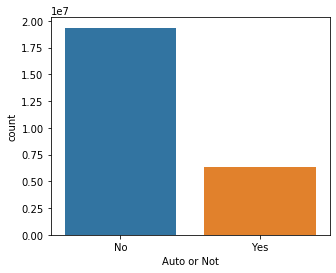

In [16]:
import seaborn as sns
sns.barplot(x="Auto or Not",y="count",data=imbalance_classes)

#### setting up training, validation and test set 

In [17]:
train_idx=th.nonzero(train_mask.squeeze()).numpy()
val_idx=th.nonzero(val_mask.squeeze()).numpy()
test_idx=th.nonzero(test_mask.squeeze()).numpy()

train_idx=th.from_numpy(train_idx).squeeze()    
val_idx=th.from_numpy(val_idx).squeeze()    
test_idx=th.from_numpy(test_idx).squeeze()

train_label=binary_label[train_idx].squeeze().numpy()
val_label=binary_label[val_idx].squeeze().numpy()
test_label=binary_label[test_idx].squeeze().numpy()

print('{:<15} {:<10,}'.format("Training set",train_idx.shape[0]))
print('{:<15} {:<10,}'.format("validation set",val_idx.shape[0]))
print('{:<15} {:<10,}'.format("test set",test_idx.shape[0]))

Training set    20,534,804
validation set  2,566,850 
test set        2,566,850 


In [18]:
##### check cuda
device="cpu"
use_cuda=args.gpu>=0 and th.cuda.is_available()
if use_cuda:
    th.cuda.set_device(args.gpu)
    device='cuda:%d' % args.gpu
print(device)

cuda:0


In [19]:
num_classes=th.unique(th.from_numpy(train_label)).shape[0]
if args.loss_weight:
    train_classes_num, train_classes_weight = get_class_count_weight(train_label,num_classes)
    loss_weight=th.tensor(train_classes_weight).to(device)
else:
    loss_weight=None

In [20]:
num_rels=g.edata['etype'].long().unique().max().item()+1
num_nodes=g.num_nodes()

# create model
model = EntityClassify(g,
                       feat_list,
                       args.h_dim,
                       n_classes,
                       num_rels,
                       num_bases=args.num_bases,
                       num_hidden_layers=args.num_layers,
                       dropout=args.dropout,
                       use_self_loop=args.use_self_loop,
                       low_mem=args.low_mem,
                       layer_norm=args.layer_norm)
if use_cuda:
    model.cuda()

model.layers

ModuleList(
  (0): RelGraphConv(
    (layer_norm_weight): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (1): RelGraphConv(
    (layer_norm_weight): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [21]:
optimizer = th.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2norm)

In [22]:
# train sampler
sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
train_loader = dgl.dataloading.NodeDataLoader(
    g, train_idx, sampler,
    batch_size=args.batch_size, shuffle=True, num_workers=args.num_worker)
# validation sampler
# we do not use full neighbor to save computation resources
val_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
val_loader = dgl.dataloading.NodeDataLoader(
    g, val_idx, val_sampler,
    batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker)

test_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
test_loader = dgl.dataloading.NodeDataLoader(
    g, test_idx, test_sampler,
    batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker)

print("The number of minibatch in training set is {:,}".format(len(train_loader)))
print("The number of minibatch in validation set is {:,}".format(len(val_loader)))
print("The number of minibatch in test set is {:,}".format(len(test_loader)))

The number of minibatch in training set is 2,006
The number of minibatch in validation set is 251
The number of minibatch in test set is 251


In [23]:
print("The total # of parameter is {:,}".format(sum([p.nelement() for p in model.parameters()]) ) )

The total # of parameter is 66,874


In [24]:
param_dict={n: p.nelement() for n, p in model.named_parameters()}
for i,j in param_dict.items():
    print("{:<70}{:<15,}".format(i,j))

node_embed.emb.usaayr.weight                                          5,440          
node_embed.emb.AGE_BAND.weight                                        448            
node_embed.emb.ORIGEL.weight                                          2,752          
node_embed.emb.ELIG2.weight                                           384            
node_embed.emb.SEX.weight                                             320            
node_embed.emb.MARST.weight                                           640            
node_embed.emb.BRANCH.weight                                          1,088          
node_embed.emb.ENLPAYGD.weight                                        1,600          
node_embed.emb.MILST.weight                                           512            
node_embed.emb.MLIST_OrigStat.weight                                  192            
node_embed.emb.STATE.weight                                           3,712          
layers.0.weight                                       

In [25]:
# %pdb
LOSS_EPOCH=[]
LABEL_TRAIN=[]

# training loop
print("start training...")

total_loss=0
losses=[]

LOGIT_train=[]
LABEL_train=[]

# th.manual_seed(args.seed)
# th.cuda.manual_seed(args.seed)
# th.cuda.manual_seed_all(args.seed)
# np.ranom.seed(args.seed)
# random.seed(args.seed)
# th.backends.cudnn.deterministic=True

for epoch in tqdm(range(0,args.n_epochs)):
    
    model.train()
    IDX=[]
    H=[]
    
    #====================================#
    #            Traning                 #
    #====================================#
    print("")
    print("========= Epoch {:} /{:}".format(epoch+1,args.n_epochs))
    print("Training...")
    t0 = time.time()
    for step, (input_nodes, seeds, blocks) in enumerate(train_loader):
        blocks = [blk.to(device) for blk in blocks]
        
        seeds=seeds.to(device)
        
        labels_train=binary_label[seeds].to(device)       
        
        input_nodes=input_nodes.to(device)
        
        logits,h = model(blocks,input_nodes)
        optimizer.zero_grad()
    
        if args.loss_weight :
            loss = F.cross_entropy(logits.view(-1, num_classes), labels_train.squeeze().to(device))
        else:
            loss = F.cross_entropy(logits.view(-1, num_classes), labels_train.squeeze().to(device),weight=loss_weight.to(device))
        
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        arg1=logits[:,1].detach().cpu().numpy()
        arg2=labels_train.cpu().numpy()
                
        train_gain = lift_gain_eval(arg1,arg2,topk=[0.01,0.05,0.10])
        
        train_acc = th.sum(logits.argmax(dim=1) == labels_train).item() / len(seeds)
        precision, recall, fscore, support = precision_recall_fscore_support(labels_train.cpu().numpy(), logits.argmax(dim=1).cpu().numpy())

        try:
            train_auc = roc_auc_score(labels_train.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
        except ValueError:
            pass
        
        prec,rec,_ = precision_recall_curve(labels_train.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
        if math.isnan(rec[0])==False:
            train_pr_auc=auc_score(rec,prec)

        IDX.extend(seeds.detach().cpu().numpy().tolist())
        H.extend(h.detach().cpu().numpy().tolist())
        LOGIT_train.extend(logits.detach().cpu().numpy().tolist())
        LABEL_train.extend(binary_label[blocks[-1].dstdata[dgl.NID].cpu().numpy()].tolist())
        
        if step%(len(train_loader)//10)==0 and not step==0:

            t1 = time.time()
            elapsed=utils.format_time(t1-t0)
            print("Batch {:} of {:} | Loss {:.3f}  | Elapsed: {:}".\
                  format(step,len(train_loader),np.mean(losses[-10:]),elapsed)) 
            
    LOSS_EPOCH.append(loss)

    LABEL_TRAIN.append(binary_label[blocks[-1].ndata[dgl.NID]['_N'].cpu().numpy()])


    model.eval()
    print()
    print("")
    print("Running Validation on training set")
    print("")
    fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, train_loader, binary_label,  device, loss_weight, num_classes)
    
    avg_loss_train=np.mean(losses_tmp)
    
    tmp_mean_pool_train=evaluate(fin_targets.reshape(-1),fin_outputs)
    
    t2=time.time()
    
    print("avg_loss: {:.2f} | True_Prediction: {:,} | False_Prediction: {:,} | accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-10%: {:.1f} |\
    ROC_AUC: {:.1%} | PR_AUC: {:.1%} | Elapsed: {:}".format(avg_loss_train, tmp_mean_pool_train["true_prediction"], tmp_mean_pool_train["false_prediction"], tmp_mean_pool_train["accuracy"], \
                                                            tmp_mean_pool_train["precision"], tmp_mean_pool_train["recall"], tmp_mean_pool_train["f1_score"], tmp_mean_pool_train["GAIN"]['10%'], \
                                                            tmp_mean_pool_train["AUC"], tmp_mean_pool_train["pr_auc"], utils.format_time(t2-t1)))

    #====================================#
    #            Validation-set          #
    #====================================#
    
    model.eval()
    print()
    print("")
    print("Running Validation on validation set")
    print("")
    
    fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, val_loader, binary_label,  device, loss_weight, num_classes)
    
    avg_loss_val=np.mean(losses_tmp)
    
    tmp_mean_pool_val=evaluate(fin_targets.reshape(-1),fin_outputs)
    
    t3=time.time()
    
    print("avg_loss: {:.2f} | True_Prediction: {:,} | False_Prediction: {:,} | accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-10%: {:.1f} |\
    ROC_AUC: {:.1%} | PR_AUC: {:.1%} | Elapsed: {:}".format(avg_loss_val, tmp_mean_pool_val["true_prediction"], tmp_mean_pool_val["false_prediction"], tmp_mean_pool_val["accuracy"], \
                                                            tmp_mean_pool_val["precision"], tmp_mean_pool_val["recall"], tmp_mean_pool_val["f1_score"], tmp_mean_pool_val["GAIN"]['10%'], \
                                                            tmp_mean_pool_val["AUC"], tmp_mean_pool_val["pr_auc"], utils.format_time(t3-t2)))
    
# if args.model_path is not None:
#     th.save(model.state_dict(), args.model_path)
    
#====================================#
#            Test-set                #
#====================================#
print()
print("")
print("Running Validation in Test Dataset")
print("")
model.eval()

fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, test_loader, binary_label,  device, loss_weight, num_classes)
    
avg_loss_test=np.mean(losses_tmp)

tmp_mean_pool_test=evaluate(fin_targets.reshape(-1),fin_outputs)

t4=time.time()

print("avg_loss: {:.2f} | True_Prediction: {:,} | False_Prediction: {:,} | accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-10%: {:.1f} |\
ROC_AUC: {:.1%} | PR_AUC: {:.1%} | Elapsed: {:}".format(avg_loss_test, tmp_mean_pool_test["true_prediction"], tmp_mean_pool_test["false_prediction"], tmp_mean_pool_test["accuracy"], \
                                                        tmp_mean_pool_test["precision"], tmp_mean_pool_test["recall"], tmp_mean_pool_test["f1_score"], tmp_mean_pool_test["GAIN"]['10%'], \
                                                        tmp_mean_pool_test["AUC"], tmp_mean_pool_test["pr_auc"], utils.format_time(t4-t3)))


  0%|          | 0/3 [00:00<?, ?it/s]

start training...

========= Epoch 1 /3
Training...
Batch 200 of 2006 | Loss 0.394  | Elapsed: 0:00:46
Batch 400 of 2006 | Loss 0.380  | Elapsed: 0:01:21
Batch 600 of 2006 | Loss 0.372  | Elapsed: 0:02:11
Batch 800 of 2006 | Loss 0.369  | Elapsed: 0:03:20
Batch 1000 of 2006 | Loss 0.367  | Elapsed: 0:04:12
Batch 1200 of 2006 | Loss 0.366  | Elapsed: 0:05:16
Batch 1400 of 2006 | Loss 0.365  | Elapsed: 0:06:43
Batch 1600 of 2006 | Loss 0.362  | Elapsed: 0:07:15
Batch 1800 of 2006 | Loss 0.362  | Elapsed: 0:08:12
Batch 2000 of 2006 | Loss 0.361  | Elapsed: 0:09:13


  0%|          | 0/2006 [00:00<?, ?it/s]



Running Validation on training set



  0%|          | 0/251 [00:00<?, ?it/s]

avg_loss: 0.49 | True_Prediction: 16,997,770 | False_Prediction: 3,537,034 | accuracy: 82.78% |  precision: 67.38% | recall: 58.02% | F1_score: 62.35% | Gain_top-10%: 0.3 |    ROC_AUC: 88.0% | PR_AUC: 69.5% | Elapsed: 0:05:34


Running Validation on validation set



 33%|███▎      | 1/3 [15:13<30:26, 913.50s/it]

avg_loss: 0.49 | True_Prediction: 2,124,463 | False_Prediction: 442,387 | accuracy: 82.77% |  precision: 67.37% | recall: 57.95% | F1_score: 62.31% | Gain_top-10%: 0.3 |    ROC_AUC: 88.0% | PR_AUC: 69.5% | Elapsed: 0:00:27

========= Epoch 2 /3
Training...
Batch 200 of 2006 | Loss 0.360  | Elapsed: 0:00:38
Batch 400 of 2006 | Loss 0.361  | Elapsed: 0:01:16
Batch 600 of 2006 | Loss 0.358  | Elapsed: 0:01:42
Batch 800 of 2006 | Loss 0.357  | Elapsed: 0:02:25
Batch 1000 of 2006 | Loss 0.359  | Elapsed: 0:02:52
Batch 1200 of 2006 | Loss 0.360  | Elapsed: 0:03:41
Batch 1400 of 2006 | Loss 0.356  | Elapsed: 0:04:12
Batch 1600 of 2006 | Loss 0.359  | Elapsed: 0:05:05
Batch 1800 of 2006 | Loss 0.360  | Elapsed: 0:05:32
Batch 2000 of 2006 | Loss 0.357  | Elapsed: 0:06:02


  0%|          | 0/2006 [00:00<?, ?it/s]



Running Validation on training set



  0%|          | 1/251 [00:00<00:27,  9.14it/s]

avg_loss: 0.52 | True_Prediction: 17,011,609 | False_Prediction: 3,523,195 | accuracy: 82.84% |  precision: 71.49% | recall: 50.24% | F1_score: 59.01% | Gain_top-10%: 0.3 |    ROC_AUC: 88.2% | PR_AUC: 69.9% | Elapsed: 0:04:25


Running Validation on validation set



 67%|██████▋   | 2/3 [27:10<14:14, 854.43s/it]

avg_loss: 0.52 | True_Prediction: 2,126,373 | False_Prediction: 440,477 | accuracy: 82.84% |  precision: 71.49% | recall: 50.22% | F1_score: 59.00% | Gain_top-10%: 0.3 |    ROC_AUC: 88.2% | PR_AUC: 69.9% | Elapsed: 0:00:25

========= Epoch 3 /3
Training...
Batch 200 of 2006 | Loss 0.360  | Elapsed: 0:00:33
Batch 400 of 2006 | Loss 0.358  | Elapsed: 0:01:02
Batch 600 of 2006 | Loss 0.357  | Elapsed: 0:01:48
Batch 800 of 2006 | Loss 0.360  | Elapsed: 0:02:17
Batch 1000 of 2006 | Loss 0.358  | Elapsed: 0:02:44
Batch 1200 of 2006 | Loss 0.358  | Elapsed: 0:03:35
Batch 1400 of 2006 | Loss 0.355  | Elapsed: 0:04:03
Batch 1600 of 2006 | Loss 0.359  | Elapsed: 0:04:35
Batch 1800 of 2006 | Loss 0.354  | Elapsed: 0:05:10
Batch 2000 of 2006 | Loss 0.358  | Elapsed: 0:07:00


  0%|          | 0/2006 [00:00<?, ?it/s]



Running Validation on training set



  0%|          | 0/251 [00:00<?, ?it/s]

avg_loss: 0.51 | True_Prediction: 17,041,397 | False_Prediction: 3,493,407 | accuracy: 82.99% |  precision: 70.40% | recall: 53.14% | F1_score: 60.56% | Gain_top-10%: 0.3 |    ROC_AUC: 88.2% | PR_AUC: 70.1% | Elapsed: 0:11:57


Running Validation on validation set



  1%|          | 2/251 [00:00<00:23, 10.65it/s]

avg_loss: 0.51 | True_Prediction: 2,130,358 | False_Prediction: 436,492 | accuracy: 83.00% |  precision: 70.44% | recall: 53.10% | F1_score: 60.56% | Gain_top-10%: 0.3 |    ROC_AUC: 88.2% | PR_AUC: 70.1% | Elapsed: 0:00:30


Running Validation in Test Dataset



100%|██████████| 251/251 [00:11<00:00, 20.99it/s]


avg_loss: 0.51 | True_Prediction: 2,130,545 | False_Prediction: 436,305 | accuracy: 83.00% |  precision: 70.40% | recall: 53.24% | F1_score: 60.63% | Gain_top-10%: 0.3 |ROC_AUC: 88.3% | PR_AUC: 70.1% | Elapsed: 0:00:25


In [26]:
tmp_mean_pool_train

{'nb_example': 20534804,
 'true_prediction': 17041397,
 'false_prediction': 3493407,
 'accuracy': 0.8298787268678094,
 'precision': 0.7039539295222259,
 'recall': 0.5313935748215068,
 'f1_score': 0.6056216470315169,
 'AUC': 0.8824745259146608,
 'pr_auc': 0.700638623330974,
 'GAIN': {'1%': 0.04, '5%': 0.17, '10%': 0.32}}

In [27]:
tmp_mean_pool_val

{'nb_example': 2566850,
 'true_prediction': 2130358,
 'false_prediction': 436492,
 'accuracy': 0.8299503282233087,
 'precision': 0.7044236587216991,
 'recall': 0.5310281650630231,
 'f1_score': 0.6055578950412343,
 'AUC': 0.8824690385470161,
 'pr_auc': 0.7014102786876544,
 'GAIN': {'1%': 0.04, '5%': 0.17, '10%': 0.32}}

In [28]:
tmp_mean_pool_test

{'nb_example': 2566850,
 'true_prediction': 2130545,
 'false_prediction': 436305,
 'accuracy': 0.8300231801624559,
 'precision': 0.7039671395938555,
 'recall': 0.5323832451870882,
 'f1_score': 0.6062687647376794,
 'AUC': 0.8826077711002912,
 'pr_auc': 0.7012635837925608,
 'GAIN': {'1%': 0.04, '5%': 0.17, '10%': 0.32}}

#### Score Test Dataset

In [31]:
if not os.path.exists("model_save"):
    os.makedirs("model_save")

In [32]:
%%time
fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, test_loader, binary_label,  device, loss_weight, num_classes)

savez_compressed("model_save/Conv_LOGIT.npz", fin_outputs)
savez_compressed("model_save/Conv_LABEL.npz", fin_targets)

# os.system("rm model_save/HGT_LOGIT.npz")
# os.system("rm model_save/HGT_LABEL.npz")

fin_logits = load("model_save/Conv_LOGIT.npz")['arr_0']
fin_targets = load("model_save/Conv_LABEL.npz")['arr_0']

tmp_test=evaluate(fin_targets.reshape(-1),fin_logits)

print("")
print("==> Running Validation on validation set \n")
print("")

print("True_Prediction: {:,} | False_Prediction: {:,} | accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-10%: {:.1f} |\
ROC_AUC: {:.1%} | PR_AUC: {:.1%}".format(tmp_test["true_prediction"], tmp_test["false_prediction"], tmp_test["accuracy"], \
                                                        tmp_test["precision"], tmp_test["recall"], tmp_test["f1_score"], tmp_test["GAIN"]['10%'], \
                                                        tmp_test["AUC"], tmp_test["pr_auc"]))

100%|██████████| 251/251 [00:11<00:00, 21.43it/s]



==> Running Validation on validation set 


True_Prediction: 2,130,545 | False_Prediction: 436,305 | accuracy: 83.00% |  precision: 70.40% | recall: 53.24% | F1_score: 60.63% | Gain_top-10%: 0.3 |ROC_AUC: 88.3% | PR_AUC: 70.1%
CPU times: user 1min 55s, sys: 8.95 s, total: 2min 4s
Wall time: 26.2 s
